<a href="https://colab.research.google.com/github/ruoyuz31/Coding-Practice/blob/main/2_Dataflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 508 HW 3 Part 2: Dataflow

Your task in this Colab notebook is to fill out the sections that are specified by **TODO** (please search the keyword `TODO` to make sure you do not miss any).

## Dataflow Simulation

This section defines the Processing Element (PE) functions for three dataflow architectures: Weight Stationary, Output Stationary, and Input Stationary. The simulation leverages the `multiprocessing` library, with PEs executed as `Process` instances. Data movement is managed using `Queue`, while results are stored in `Array`. The I/O costs is managed using `Value`, you need to update the corresponding values when implementing the `worker()` and `run()` functions.

Your task is to correctly route weights, activations, and partial sums according to each dataflow strategy. The number of PEs is configured to match each stationary approach.

**Note**: Multi-processing can introduce deadlocks or resource contention. Ensure thorough debugging to prevent infinite execution loops.


## Global Variable Settings

We first initialize multiprocessing tools, sets up debug flags, generates random activations and weights, and prints these values.

In [1]:
import multiprocessing
from multiprocessing import Process, Queue, Array, Value
from queue import Empty
import random

NUM_ACTIVATIONS = 8
NUM_WEIGHTS = 3
DEBUG = True

# Generate test data
weights = [random.uniform(0, 1) for _ in range(NUM_WEIGHTS)]
activations = [random.uniform(0, 1) for _ in range(NUM_ACTIVATIONS)]

print(f"Weights: {weights:}")
print(f"Activations: {activations}")

Weights: [0.23652218060055274, 0.6098681281096653, 0.09332802660269246]
Activations: [0.5147010991517658, 0.9092204163793883, 0.5888200790820967, 0.33560574641286267, 0.9260788485190737, 0.06368502651764074, 0.47822075192313684, 0.2565323589392431]


#### `DataflowBase`
This is the base class for simulating dataflow architectures. It provides foundational structures and methods for derived classes, including:
- Storing processing element (PE) configurations.
- Computing ground truth values for validation.
- Defining the `worker` method (to be implemented by subclasses).
- A `run` method placeholder for executing the simulation.

**Important**
- We use `Queue` to simulate the datacasting process; the data format to mimic the transmission between external memories and PE register files is `(time_step: int, values: float)`
- The shift and padding is done by the control logic in the `run()` method, so make sure that you pass the data correctly in the functions.

In [2]:
class DataflowBase:
    def __init__(self, num_pes, weights, activations, debug=False):
        self.num_pes = num_pes
        self.weights = weights
        self.activations = activations
        self.debug = debug

        self.num_activations = len(activations)
        self.num_weights = len(weights)
        self.num_outputs = self.num_activations - self.num_weights + 1

        # Store processes
        self.processes = []

        # count measurements
        self.cnt_memoryIO = Value('i', 0)
        self.cnt_registerIO = Value('i', 0)

    def calculate_ground_truth(self):
        """Generate reference results for validation"""
        gt = [0.0] * (self.num_outputs)
        for i in range(len(gt)):
            for k in range(self.num_weights):
                gt[i] += self.weights[k] * self.activations[i + k]
        return gt

    def worker(self, pe_id, top_q, left_q, right_q):
        pass

    def run(self):
        pass

    def IO_measurement(self):
        print(f"Number of I/O from the external memory:{self.cnt_memoryIO.value}")
        print(f"Number of I/O from the PE register files:{self.cnt_registerIO.value}")


## Weight Stationary Configuration

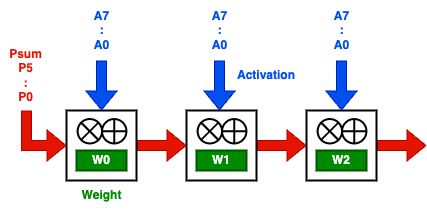

### `WeightStationary`
A subclass of `DataflowBase` implementing a weight-stationary dataflow. This approach keeps weights fixed in processing elements (PEs) while activations stream through. The class:

- Initializes shared queues for activation broadcasting and partial sum accumulation.
- Each PE:
  - Retrieves activations from the broadcast queue along with their **timestep**.
  - Checks if the **timestep** falls within its valid computation range.
  - Retrieves activations from the broadcast queue.
  - Multiplies the received activation with its fixed weight and accumulates the result with a running partial sum.
  - Passes the updated partial sum to the next PE.
- Implements the `run()` method, which:
  - Spawns worker processes for PEs.
  - Broadcasts activations, ensuring each activation is associated with a **timestep**.
  - Collects final outputs from the rightmost queue.

**Timestep Usage:**  
The **timestep** indicates when an activation enters the pipeline. Each PE processes activations only if the **timestep** falls within its valid computation window.

**Important**
- We use `Queue` to simulate the datacasting process; the data format to mimic the transmission between external memories and PE register files is `(time_step: int, values: float)`
- The shift and padding is done by the control logic in the `run()` method, so make sure that you pass the data correctly in the functions.

### **TODO 1:**

Complete the missing code in the WeightStationary `worker` function below.

In [35]:
class WeightStationary(DataflowBase):
    def __init__(self, num_pes, weights, activations, debug=False):
        super().__init__(num_pes, weights, activations, debug)

        # Initialize shared data structures
        self.broadcast_queues = [Queue() for _ in range(self.num_pes)]
        self.partial_sum_queues = [Queue() for _ in range(self.num_pes + 1)]
        self.output_regfiles = Array('d', [0.0] * (self.num_outputs))
        self.pe_regfiles = Array('d', weights)

    def worker(self, pe_id, top_q, left_q, right_q):
        """Processing Element (PE) worker function."""
        while True:
            try:
                time_step, activation = top_q.get(timeout=1)
            except Empty:
                break

            # Check valid time step range for this PE
            if time_step >= pe_id:
                # Perform PE function
                try:
                    prev_psum = left_q.get(timeout=1)
                except Empty:
                    break
                new_psum = prev_psum + self.pe_regfiles[pe_id] * activation
                right_q.put(new_psum)

                if self.debug:
                    print(f"PE{pe_id}: ts={time_step}, weight={self.pe_regfiles[pe_id]:.4f}, activation={activation:.4f}, "
                          f"prev_psum={prev_psum:.4f}, new_psum={new_psum:.4f}\n")

        print(f"PE{pe_id} exiting")

    def run(self):
        """Execute the simulator pipeline"""
        # Prepare worker processes
        for pe_id in range(self.num_pes):
            self.processes.append(Process(
                target=self.worker,
                args=(
                    pe_id,
                    self.broadcast_queues[pe_id],
                    self.partial_sum_queues[pe_id],
                    self.partial_sum_queues[pe_id + 1]
                )
            ))

        # Initialize partial sums for the leftmost queue
        for _ in range(self.num_outputs):
            self.partial_sum_queues[0].put(0.0)

        # Broadcast activations to all workers
        for ts, activation in enumerate(self.activations):
            for q in self.broadcast_queues:
                # casting the activations to the PEs
                q.put((ts, activation))
                # update the memory I/O counts
                self.cnt_memoryIO.value += 1

        # Start all processes
        for p in self.processes:
            p.start()

        # Collect outputs from the rightmost queue
        for i in range(self.num_outputs):
            self.output_regfiles[i] = self.partial_sum_queues[-1].get()

        # Wait for all processes to complete
        for p in self.processes:
            p.join()

        return list(self.output_regfiles)

Next, we initialize and run the `WeightStation` simulator to compute outputs using a weight-stationary dataflow. It first creates the simulator with the given weights, activations, and processing elements. The `run()` method executes the simulation, and the results are printed. Then, the ground truth is computed using a direct method and compared to the simulation results to check for correctness.

In [36]:
# Create and run simulator
simulator = WeightStationary(
    num_pes=NUM_WEIGHTS,
    weights=weights,
    activations=activations,
    debug=DEBUG
)


# Run simulator implementation
result = simulator.run()
print("\nSimulation results:", [f"{v:.4f}" for v in result])

# Calculate ground truth for validation
gt = simulator.calculate_ground_truth()
print("\nGround truth:", [f"{v:.4f}" for v in gt])

# Compare results
print("\nResults matched:", result == gt)

# Print the I/O communication cost
print("\nCommunication costs:")
simulator.IO_measurement()

PE0: ts=0, weight=0.2365, activation=0.5147, prev_psum=0.0000, new_psum=0.1217
PE1: ts=1, weight=0.6099, activation=0.9092, prev_psum=0.1217, new_psum=0.6762


PE0: ts=1, weight=0.2365, activation=0.9092, prev_psum=0.0000, new_psum=0.2151
PE1: ts=2, weight=0.6099, activation=0.5888, prev_psum=0.2151, new_psum=0.5742


PE1: ts=3, weight=0.6099, activation=0.3356, prev_psum=0.1393, new_psum=0.3439
PE0: ts=2, weight=0.2365, activation=0.5888, prev_psum=0.0000, new_psum=0.1393


PE2: ts=2, weight=0.0933, activation=0.5888, prev_psum=0.6762, new_psum=0.7312
PE0: ts=3, weight=0.2365, activation=0.3356, prev_psum=0.0000, new_psum=0.0794
PE1: ts=4, weight=0.6099, activation=0.9261, prev_psum=0.0794, new_psum=0.6442


PE0: ts=4, weight=0.2365, activation=0.9261, prev_psum=0.0000, new_psum=0.2190


PE2: ts=3, weight=0.0933, activation=0.3356, prev_psum=0.5742, new_psum=0.6055
PE0: ts=5, weight=0.2365, activation=0.0637, prev_psum=0.0000, new_psum=0.0151
PE1: ts=5, weight=0.6099, activation=0.063

## Output Stationary Configuration

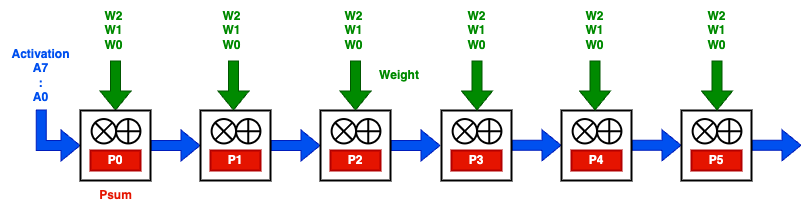

### `OutputStationary`
A subclass of `DataflowBase` implementing an output-stationary dataflow. Here, partial sums remain stationary in the PEs while weights and activations are streamed through. The class:

- Uses queues to broadcast weights and pass activations between PEs.
- Each PE:
  - Fetches activations from the queue, each tagged with a **timestep**.
  - Checks if the **timestep** falls within its valid computation range.
  - Retrieves weights from the broadcast queue.
  - Multiplies the received weight with the activation and accumulates the result in its local register file.
  - Passes activations to the next PE.
- Implements the `run()` method, which:
  - Spawns worker processes for PEs.
  - Feeds activations with their **timestep** and broadcasts weights.
  - Collects final results from the PE registers.

**Timestep Usage:**  
The **timestep** determines which PE should process an activation. A PE only updates its register file if the **timestep** falls within its assigned computation range.

**Important**
- We use `Queue` to simulate the datacasting process; the data format to mimic the transmission between external memories and PE register files is `(time_step: int, values: float)`
- The shift and padding is done by the control logic in the `run()` method, so make sure that you pass the data correctly in the functions.


### **TODO 2:**

Complete the missing code in the OutputStationary `worker` function below.

In [ ]:
class OutputStationary(DataflowBase):
    def __init__(self, num_pes, weights, activations, debug=False):
        super().__init__(num_pes, weights, activations, debug)

        # Initialize shared data structures
        self.broadcast_queues = [Queue() for _ in range(self.num_pes)]
        self.activation_queues = [Queue() for _ in range(self.num_pes + 1)]
        self.pe_regfiles = Array('d', [0.0] * (self.num_pes))

    def worker(self, pe_id, top_q, left_q, right_q):
        """Processing Element (PE) worker function."""
        while True:
            try:
                time_step, activation = left_q.get(timeout=1)
            except Empty:
                break

            # Check valid time step range for this PE
            if time_step >= pe_id:
                # Perform PE function
                try:
                    weight = top_q.get(timeout=1)
                except Empty:
                    break
                prev_psum = self.pe_regfiles[pe_id]
                new_psum = prev_psum + weight * activation

                # Read from the PE register files, update the cnt
                self.cnt_registerIO.value += 1

                if self.debug:
                    print(f"PE{pe_id}: ts={time_step}, weight={self.pe_regfiles[pe_id]:.4f}, activation={activation:.4f}, "
                          f"prev_psum={prev_psum:.4f}, new_psum={new_psum:.4f}\n")

            right_q.put((time_step, activation))

        print(f"PE{pe_id} exiting")

    def run(self):
        """Execute the simulator pipeline"""
        # Prepare worker processes
        for pe_id in range(self.num_pes):
            p = Process(target=self.worker, args=(
                pe_id,
                self.broadcast_queues[pe_id],
                self.activation_queues[pe_id],
                self.activation_queues[pe_id + 1]
            ))
            self.processes.append(p)

        # Send activation to the leftmost worker
        for ts, activation in enumerate(self.activations):
            self.activation_queues[0].put((ts, activation))

        # Broadcast weights to all workers
        for weight in self.weights:
            for q in self.broadcast_queues:
                # casting the activations to the PEs
                q.put(weight)
                # update the memory I/O counts
                self.cnt_memoryIO.value += 1

        # Start all processes
        for p in self.processes:
            p.start()

        # Wait for processes to finish
        for p in self.processes:
            p.join()

        return list(self.pe_regfiles)

In [ ]:
# Create and run simulator
simulator = OutputStationary(
    num_pes=NUM_ACTIVATIONS-NUM_WEIGHTS+1,
    weights=weights,
    activations=activations,
    debug=DEBUG
)

# Run simulator implementation
result = simulator.run()
print("\nSimulation results:", [f"{v:.4f}" for v in result])

# Calculate ground truth for validation
gt = simulator.calculate_ground_truth()
print("\nGround truth:", [f"{v:.4f}" for v in gt])

# Compare results
print("\nResults matched:", result == gt)

# Print the I/O communication cost
print("\nCommunication costs:")
simulator.IO_measurement()

## Input Stationary Configuration

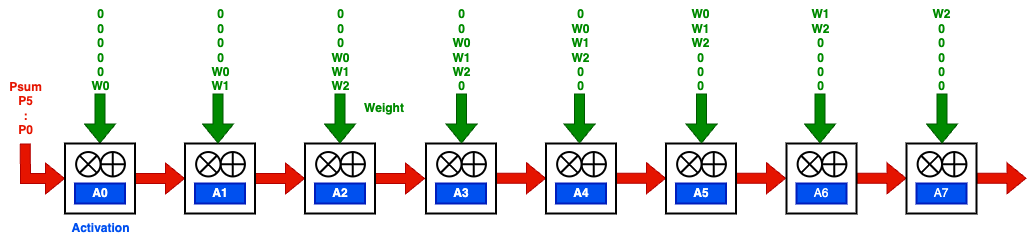

### `InputStationary`
A subclass of `DataflowBase` implementing an input-stationary dataflow, where activations remain fixed in the PEs while weights and partial sums are streamed through. The class:

- Initializes shared queues for weight broadcasting and partial sum accumulation.
- Each PE:
  - Receives weights from a broadcast queue, each associated with a **timestep**.
  - Checks if the **timestep** falls within its valid computation range.
  - Multiplies the received weight with its fixed activation and accumulates the result with a running partial sum.
  - Passes the updated partial sum to the next PE.
  - If outside the valid computation window, it simply forwards the partial sum.
- Implements the `run()` method, which:
  - Spawns worker processes for PEs.
  - Distributes weights dynamically based on **timestep**.
  - Collects final results from the rightmost queue.

**Timestep Usage:**  
The **timestep** determines which weight is assigned to each PE at a given moment. If a PE is not within the valid computation window for that **timestep**, it simply forwards the partial sum.

**Important**
- We use `Queue` to simulate the datacasting process; the data format to mimic the transmission between external memories and PE register files is `(time_step: int, values: float)`
- The shift and padding is done by the control logic in the `run()` method, so make sure that you pass the data correctly in the functions.


### **TODO 3:**

Complete the missing code in the InputStationary `worker` function below.

In [ ]:
class InputStationary(DataflowBase):
    def __init__(self, num_pes, weights, activations, debug=False):
        super().__init__(num_pes, weights, activations, debug)

        # Initialize shared data structures
        self.broadcast_queues = [Queue() for _ in range(self.num_pes)]
        self.partial_sum_queues = [Queue() for _ in range(self.num_pes + 1)]
        self.output_regfiles = Array('d', [0.0] * (self.num_outputs))
        self.pe_regfiles = Array('d', activations)

    def worker(self, pe_id, weight_q, right_q, left_q):
        """Processing Element (PE) worker function."""
        while True:
            try:
                time_step, weight = weight_q.get(timeout=1)  # avoid infinite blocking
            except Empty:
                break

            # Check valid time step range for this PE
            if ():
                # If in the convolution window, perform PE function


                # Read from the PE register files, update the cnt
                self.cnt_registerIO.value += 1

                if self.debug:
                    print(f"PE{pe_id}: ts={time_step}, weight={weight:.4f}, activation={activation:.4f}, "
                          f"prev_psum={prev_psum:.4f}, new_psum={new_psum:.4f}\n")
            else:
                # Otherwise, perform PE function



        if self.debug:
            print(f"PE{pe_id} exiting")


    def run(self):
        """Execute the simulator pipeline"""
        # Prepare worker processes
        for pe_id in range(self.num_pes):
            p = Process(
                target=self.worker,
                args=(
                    pe_id,
                    self.broadcast_queues[pe_id],
                    self.partial_sum_queues[pe_id + 1],
                    self.partial_sum_queues[pe_id],
                )
            )
            self.processes.append(p)

        # Initialize partial sums for the leftmost queue
        for _ in range(self.num_outputs):
            self.partial_sum_queues[0].put(0.0)

        # Broadcast weights with dummy zero values
        for ts in range(self.num_outputs):
            for i in range(self.num_pes):
                if ts <= i <= ts + len(self.weights) - 1:
                    # For valid indices, choose the proper weight:
                    weight = self.weights[i - ts]
                    # update the memory I/O counts
                    self.cnt_memoryIO.value += 1
                else:
                    weight = 0.0
                # casting the activations to the PEs
                self.broadcast_queues[i].put((ts, weight))

        # Start all worker processes
        for p in self.processes:
            p.start()

        # Collect outputs from the rightmost queue
        for i in range(self.num_outputs):
            self.output_regfiles[i] = self.partial_sum_queues[-1].get()

        # Wait for processes to finish
        for p in self.processes:
            p.join()

        return list(self.output_regfiles)

In [ ]:
# Create and run simulator
simulator = InputStationary(
    num_pes=NUM_ACTIVATIONS,
    weights=weights,
    activations=activations,
    debug=DEBUG
)

# Run simulator implementation
result = simulator.run()
print("\nSimulation results:", [f"{v:.4f}" for v in result])

# Calculate ground truth for validation
gt = simulator.calculate_ground_truth()
print("\nGround truth:", [f"{v:.4f}" for v in gt])

# Compare results
print("\nResults matched:", result == gt)

# Print the I/O communication cost
print("\nCommunication costs:")
simulator.IO_measurement()